DatasetDict({
    train: Dataset({
        features: ['inputs', 'label'],
        num_rows: 9843
    })
    test: Dataset({
        features: ['inputs', 'label'],
        num_rows: 2468
    })
})
Before: (8192, 3)
After: (6795, 3)


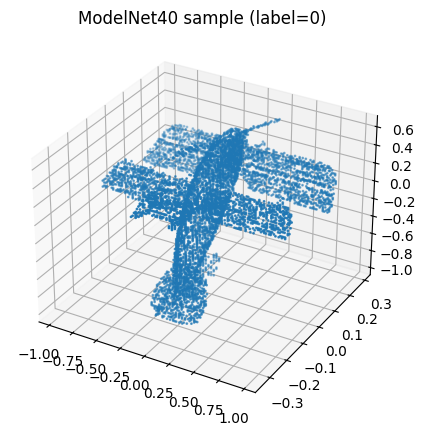

In [19]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# 1) Load
ds = load_dataset("jxie/modelnet40")  # has train/test splits in parquet
print(ds)

# 2) Grab a point cloud and label
ex = ds["train"][0]
pts = np.array(ex["inputs"], dtype=np.float32)   # shape ~ (2048, 3)
label = ex["label"]

pts = invdisc(disc(torch.from_numpy(pts))).numpy()
# remove duplicates
print(f"Before: {pts.shape}")
pts = np.unique(pts, axis=0)
print(f"After: {pts.shape}")

# 3) Quick scatter viz
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
ax.set_title(f"ModelNet40 sample (label={label})")
plt.show()


Ranges:
x: [-0.962, 0.976]
y: [-0.332, 0.297]
z: [-0.974, 0.600]


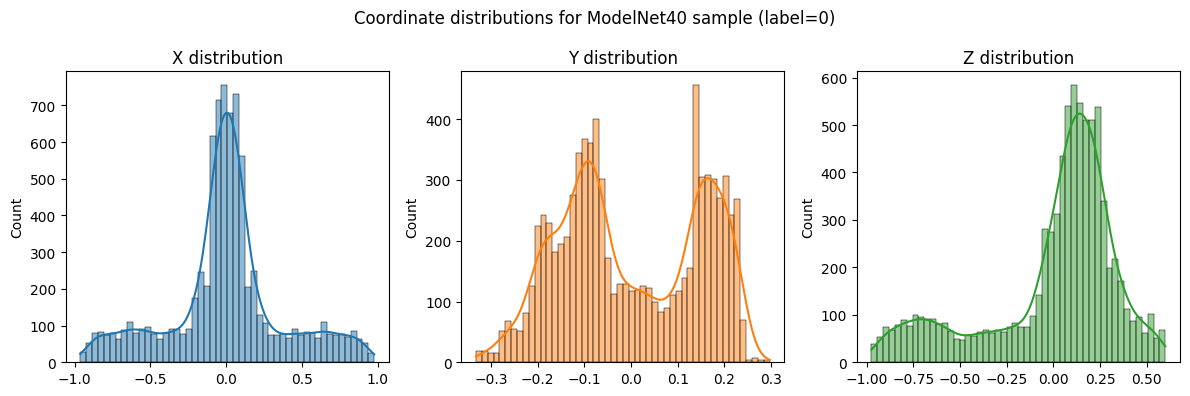

In [5]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load
ds = load_dataset("jxie/modelnet40")
ex = ds["train"][0]
pts = np.array(ex["inputs"], dtype=np.float32)   # (2048, 3)
label = ex["label"]

# 2) Compute ranges
x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
print("Ranges:")
print(f"x: [{x.min():.3f}, {x.max():.3f}]")
print(f"y: [{y.min():.3f}, {y.max():.3f}]")
print(f"z: [{z.min():.3f}, {z.max():.3f}]")

# 3) Histograms with seaborn
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(x, bins=50, ax=axes[0], kde=True, color="tab:blue")
axes[0].set_title("X distribution")

sns.histplot(y, bins=50, ax=axes[1], kde=True, color="tab:orange")
axes[1].set_title("Y distribution")

sns.histplot(z, bins=50, ax=axes[2], kde=True, color="tab:green")
axes[2].set_title("Z distribution")

plt.suptitle(f"Coordinate distributions for ModelNet40 sample (label={label})")
plt.tight_layout()
plt.show()


### Data processing

In [22]:
import torch
from sklearn.cluster import KMeans


def disc(
    points: torch.Tensor, n_bins: int = 128, min_val: float = -1.0, max_val: float = 1.0
) -> torch.Tensor:
    """
    Discretize 3D point cloud into integer bins [0, n_bins-1] along each axis.

    Args:
        points (torch.Tensor): (N, 3) float tensor of coordinates.
        n_bins (int): Number of bins per axis.
        min_val (float): Minimum value of the range.
        max_val (float): Maximum value of the range.

    Returns:
        torch.Tensor: (N, 3) integer tensor of bin indices in [0, n_bins-1].
    """
    scale = (n_bins - 1) / (max_val - min_val)
    out = torch.round((points - min_val) * scale).to(torch.int32)
    return torch.clamp(out, 0, n_bins - 1)


def invdisc(
    indices: torch.Tensor, n_bins: int = 128, min_val: float = -1.0, max_val: float = 1.0
) -> torch.Tensor:
    """
    Map discretized integer bins back to continuous coordinates (bin centers).

    Args:
        indices (torch.Tensor): (N, 3) integer tensor of bin indices.
        n_bins (int): Number of bins per axis.
        min_val (float): Minimum value of the range.
        max_val (float): Maximum value of the range.

    Returns:
        torch.Tensor: (N, 3) float tensor of bin center coordinates.
    """
    step = (max_val - min_val) / (n_bins - 1)
    return min_val + indices.to(torch.float32) * step




def cluster(x: torch.Tensor, K: int, seed: int = 0) -> torch.Tensor:
    """
    Run KMeans on x and return cluster centers.

    Args:
        x (torch.Tensor): (N, D) float tensor on CPU or GPU.
        K (int): number of clusters.
        seed (int): random seed for reproducibility.

    Returns:
        torch.Tensor: (K, D) float tensor of cluster centers (on same device as x).
    """
    device = x.device
    x_np = x.detach().cpu().numpy()

    km = KMeans(n_clusters=K, n_init="auto", random_state=seed)
    km.fit(x_np)

    centers = torch.from_numpy(km.cluster_centers_).to(device=device, dtype=x.dtype)
    return centers




DatasetDict({
    train: Dataset({
        features: ['inputs', 'label'],
        num_rows: 9843
    })
    test: Dataset({
        features: ['inputs', 'label'],
        num_rows: 2468
    })
})
Points: (1024, 3)


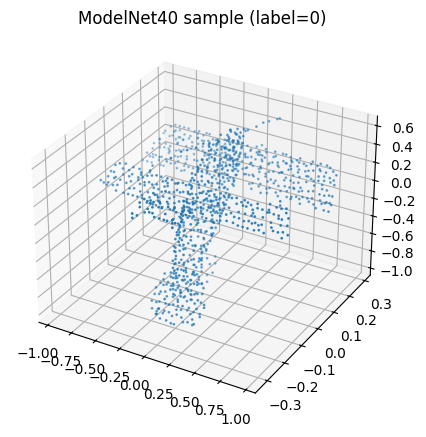

In [29]:
# Data processing

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# 1) Load
ds = load_dataset("jxie/modelnet40")  # has train/test splits in parquet
print(ds)

# 2) Grab a point cloud and label
ex = ds["train"][0]
pts = np.array(ex["inputs"], dtype=np.float32)   # shape ~ (2048, 3)
label = ex["label"]

pts = invdisc(disc(cluster(torch.from_numpy(pts), K=1024))).numpy()  # (1024, 3)
print(f"Points: {pts.shape}")


# 3) Quick scatter viz
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
ax.set_title(f"ModelNet40 sample (label={label})")
plt.show()
